In [13]:
# importing libraries
import pandas as pd
import numpy as np

import urllib.request
import os 

# For Visualization 
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
import seaborn as sns


from sklearn.manifold import TSNE

import glob

# Model Training
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Function to create cnn model
from imutils.video import VideoStream
from imutils.video import FPS
import argparse
import imutils
import time
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.models import load_model
from keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.optimizers import Adam
import cv2

In [4]:
# Trained and Tested for classes
class_names = ['fish','triangle','train','computer','submarine','pizza','suitcase',
               'streetlight','bicycle','apple','mushroom','broom','scissors',
               'vase','star','truck','spreadsheet','snail','flower','sun','van','snowflake',
               'toe','dog','butterfly','tooth','rainbow','sailboat','sock',
               'squiggle','hat','ant','speedboat','bench','wristwatch','toothbrush','shark',
               'sandwich','stairs','toaster','helicopter','bed',
                'calculator','whale','television','elephant','snake','grapes','firetruck','tree','shoe']
                

len(class_names)

51

In [5]:
# Random state.
RS = 100

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})



# Download classes mentioned in list and reshape data
def download_and_load(test_split = 0.2, max_items_per_class = 15000):
    root = 'dataset_v2'
    os.mkdir('dataset_v2')
    print('downloading ...')
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in class_names:
        path = base+c+'.npy'
        print(path)
        urllib.request.urlretrieve(path, f'{root}/{c}.npy')
        print('loading ...')
  
    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    #load each data file 
    for idx, file in enumerate(class_names):
        data = np.load(f'{root}/{file}.npy')
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)
        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)
    data = None
    labels = None
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]
    #reshape and inverse the colors 
    x = 255 - np.reshape(x, (x.shape[0], 28, 28))

    #separate into training and testing 
    test_size  = int(x.shape[0]/100*(test_split*100))
    x_test = x[0:test_size, :]
    y_test = y[0:test_size]
    x_train = x[test_size:x.shape[0], :]
    y_train = y[test_size:y.shape[0]]
    
    print('Training Data : ', x_train.shape[0])
    print('Testing  Data : ', x_test.shape[0])
    return x_train, y_train, x_test, y_test, class_names

In [6]:
# Do some visualization
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, class_names[i], fontsize=15)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
def plot_tsne(X, y):
    print('calculating tsne ...')
    proj = TSNE(random_state=RS).fit_transform(X)
    scatter(proj, y)

In [7]:
# Call download and load function & split into training testing
x_train, y_train, x_test, y_test, class_names = download_and_load()

downloading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fish.npy
loading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/triangle.npy
loading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/train.npy
loading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/computer.npy
loading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/submarine.npy
loading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pizza.npy
loading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/suitcase.npy
loading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/streetlight.npy
loading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bicycle.npy
loading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
loading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/mushroo

In [9]:
# Visualizing 10 classes data
def visualize_classes():
    for i in range(0, 10):
        img_batch = x_train[y_train == i][0:10]
        img_batch = np.reshape(img_batch, (img_batch.shape[0]*img_batch.shape[1], img_batch.shape[2]))
        if i > 0:
            img = np.concatenate([img, img_batch], axis = 1)
        else:
            img = img_batch
    plt.figure(figsize=(10,20))
    plt.axis('off')
    plt.imshow(img)

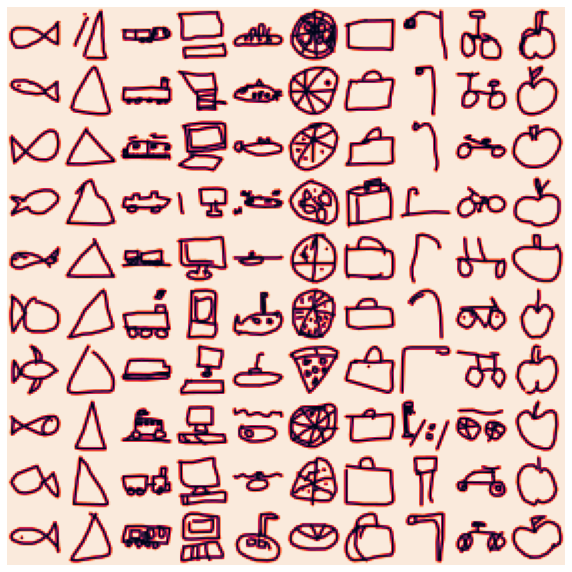

In [10]:
visualize_classes()

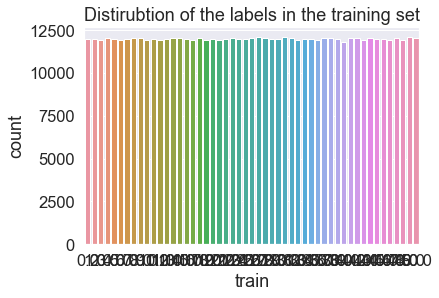

In [11]:
data = {}
data['train'] = y_train
df = pd.DataFrame.from_dict(data)
ax = sns.countplot(x = 'train', data=df).set_title("Distirubtion of the labels in the training set")

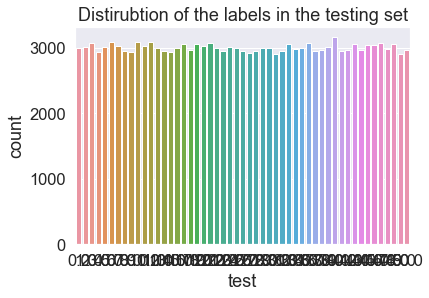

In [12]:
data = {}
data['test'] = y_test
df = pd.DataFrame.from_dict(data)
ax = sns.countplot(x = 'test', data=df).set_title("Distirubtion of the labels in the testing set")

In [13]:
# Reshaping and categorical conversions
image_size = 28

# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_test = keras.utils.to_categorical(y_test, len(class_names))

In [14]:
# Creating sequential model - CNN
def create_cnn_model_v2(num_classes, input_shape) :
    
    # Initialising the CNN
    model = Sequential()
    
    # 1 - Convolution Layer
    #ReLU function to introduce non linearity in our CNN
    model.add(Conv2D(30, (5, 5), input_shape=input_shape, activation='relu'))
    
#     improves the performance and stability of NNs by providing inputs with zero mean and unit varianc
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #
    model.add(Dropout(0.25)) #reduces overfitting
    
    # 2nd Convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #max,sum,mean
    model.add(Dropout(0.25)) #reduces overfitting
    
    # Flattening
    model.add(Flatten())
    
    # Fully connected layer 1st layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Fully connected layer 2nd layer
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(num_classes, activation='softmax'))
    opt = Adam(lr=0.001)

    # compile model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
# Creating and fitting of model
n_classes = len(class_names)
input_shape = (28, 28, 1)
model = create_cnn_model_v2(num_classes=n_classes, input_shape=input_shape)
hist = model.fit(x=x_train, y=y_train, batch_size=100, epochs=10,validation_split=0.1)

Epoch 1/10
5508/5508 [==============================] - 391s 71ms/step - loss: 1.5089 - accuracy: 0.6026 - val_loss: 0.8943 - val_accuracy: 0.7638
Epoch 2/10
5508/5508 [==============================] - 366s 67ms/step - loss: 1.0780 - accuracy: 0.7141 - val_loss: 0.7589 - val_accuracy: 0.8007
Epoch 3/10
5508/5508 [==============================] - 363s 66ms/step - loss: 0.9985 - accuracy: 0.7369 - val_loss: 0.7727 - val_accuracy: 0.7976
Epoch 4/10
5508/5508 [==============================] - 348s 63ms/step - loss: 0.9527 - accuracy: 0.7484 - val_loss: 0.6729 - val_accuracy: 0.8229
Epoch 5/10
5508/5508 [==============================] - 352s 64ms/step - loss: 0.9256 - accuracy: 0.7561 - val_loss: 0.6622 - val_accuracy: 0.8253
Epoch 6/10
5508/5508 [==============================] - 343s 62ms/step - loss: 0.9031 - accuracy: 0.7617 - val_loss: 0.6724 - val_accuracy: 0.8231
Epoch 7/10
5508/5508 [==============================] - 342s 62ms/step - loss: 0.8863 - accuracy: 0.7665 - val_loss: 0

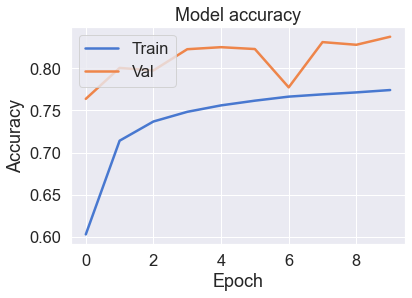

In [16]:
#Visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [17]:
# Evaluating 
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 83.98%


True Label  submarine
Pred Label  speedboat


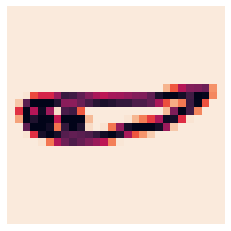

In [18]:
#get predictions and true labels
yhat = np.argmax(model.predict(x_test), axis = 1)
y    = np.argmax(y_test, axis = 1)

#get the indices of the bad labels 
bad_labels = np.argwhere((y == yhat) == False).squeeze()

#choose a random index with incorrect label 
idx = np.random.choice(bad_labels)

print('True Label ',class_names[y[idx]])
print('Pred Label ',class_names[yhat[idx]])
plt.imshow(x_test[idx].squeeze())
plt.axis('off')
plt.show()

# Prediction Examples

In [34]:
# Please define model name here

model_name = ''

model = load_model(model_name)

OSError: SavedModel file does not exist at: /{saved_model.pbtxt|saved_model.pb}

In [33]:
temp = 'alarm clock_9.png'
print(temp)
im_gray = cv2.imread(temp, cv2.IMREAD_GRAYSCALE)
print(im_gray)


img = cv2.resize(im_gray, (28, 28), interpolation=cv2.INTER_AREA)
img = (img-255)/255
print(img.shape)

# displaying image
print(plt.imshow(img, cmap='gray'))
img=img.reshape(1,28,28,1)

alarm clock_9.png
None


error: OpenCV(4.2.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [24]:
prediction = model.predict_classes(img)
prediction

NameError: name 'model' is not defined

In [22]:
prediction = model.predict_classes(img)
label_map[prediction[0]]

NameError: name 'img' is not defined

In [6]:
# input image and find top 3 classes with respective classes
temp = 'apple_7.png'

im_gray = cv2.imread(temp, cv2.IMREAD_GRAYSCALE)
print(im_gray.shape)

img = cv2.resize(im_gray, (28, 28), interpolation=cv2.INTER_AREA)
img = (img-255)/255
print(img.shape)

# displaying image
print(plt.imshow(img, cmap='gray'))

img=img.reshape(1,28,28,1)

# predict all probabilities of input
probabilities = model.predict_proba(img)
# find sorted(smallest to largest prob.) index
prob_index = probabilities.argsort()[::-3]
list_prob = prob_index[0].tolist()
top_prob = list_prob[-3:]
top_prob.reverse()
# find sorted(smallest to largest prob.) index
prob_index = probabilities.argsort()[::-3]
list_prob = prob_index[0].tolist()
top_prob = list_prob[-3:]
top_prob.reverse()
print("Top 3 clases with resp. probabilities:")
for i in top_prob:
    print(label_map[i], probabilities[0][i])

AttributeError: 'NoneType' object has no attribute 'shape'